In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler

# Define relative file path for training data
train_file = "../Data/Train/trains1990s.csv"

# Load Training Data
train_df = pd.read_csv(train_file, parse_dates=['observation_date'])
train_df = train_df.rename(columns={'fred_PCEPI': 'PCE'})
train_df.set_index('observation_date', inplace=True)

# Fit the scaler on the training data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df[['PCE']])

# Convert the scaled data to 1D arrays
train_series = train_scaled.flatten()

# Create Sequences from the Data
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        xs.append(data[i : i + seq_length])
        ys.append(data[i + seq_length])
    return np.array(xs), np.array(ys)

# Set the sequence length
sequence_length = 12
X_train, y_train = create_sequences(train_series, sequence_length)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)

batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)


/var/folders/l2/ywnjs44s40s1str7m8_h1nch0000gn/T/ipykernel_8065/1653587750.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train_df = pd.read_csv(train_file, parse_dates=['observation_date'])


In [27]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1, output_size=1):
        super(LSTMModel, self).__init__()
        # Define computation device (GPU if available, otherwise CPU)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # Define a fully connected layer for the final output
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Initialise hidden state and cell state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate through the LSTM
        out, _ = self.lstm(x, (h0, c0))
        # Take the output from the last time step
        out = out[:, -1, :]
        out = self.fc(out)
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel().to(device)

In [31]:
# Model training
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

validation_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    
    train_loss /= len(train_loader.dataset)
    validation_losses.append(train_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs} - Validation Loss: {train_loss:.4f}")

# Making predictions
model.eval()
predictions = []
actuals = []

dates = train_df.index[sequence_length:]

with torch.no_grad():
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        predictions.append(outputs.cpu().numpy())
        actuals.append(targets.cpu().numpy())

# Concatenate batches into single arrays
predictions = np.concatenate(predictions)
actuals = np.concatenate(actuals)

# Inverse transform the normalised predictions and actual values back to the original scale
predictions_inv = scaler.inverse_transform(predictions)
actuals_inv = scaler.inverse_transform(actuals)


Epoch 1/50 - Validation Loss: 0.0012
Epoch 2/50 - Validation Loss: 0.0003
Epoch 3/50 - Validation Loss: 0.0002
Epoch 4/50 - Validation Loss: 0.0001
Epoch 5/50 - Validation Loss: 0.0001
Epoch 6/50 - Validation Loss: 0.0001
Epoch 7/50 - Validation Loss: 0.0001
Epoch 8/50 - Validation Loss: 0.0001
Epoch 9/50 - Validation Loss: 0.0001
Epoch 10/50 - Validation Loss: 0.0001
Epoch 11/50 - Validation Loss: 0.0001
Epoch 12/50 - Validation Loss: 0.0001
Epoch 13/50 - Validation Loss: 0.0001
Epoch 14/50 - Validation Loss: 0.0001
Epoch 15/50 - Validation Loss: 0.0001
Epoch 16/50 - Validation Loss: 0.0001
Epoch 17/50 - Validation Loss: 0.0001
Epoch 18/50 - Validation Loss: 0.0001
Epoch 19/50 - Validation Loss: 0.0001
Epoch 20/50 - Validation Loss: 0.0001
Epoch 21/50 - Validation Loss: 0.0001
Epoch 22/50 - Validation Loss: 0.0001
Epoch 23/50 - Validation Loss: 0.0001
Epoch 24/50 - Validation Loss: 0.0001
Epoch 25/50 - Validation Loss: 0.0001
Epoch 26/50 - Validation Loss: 0.0002
Epoch 27/50 - Validat

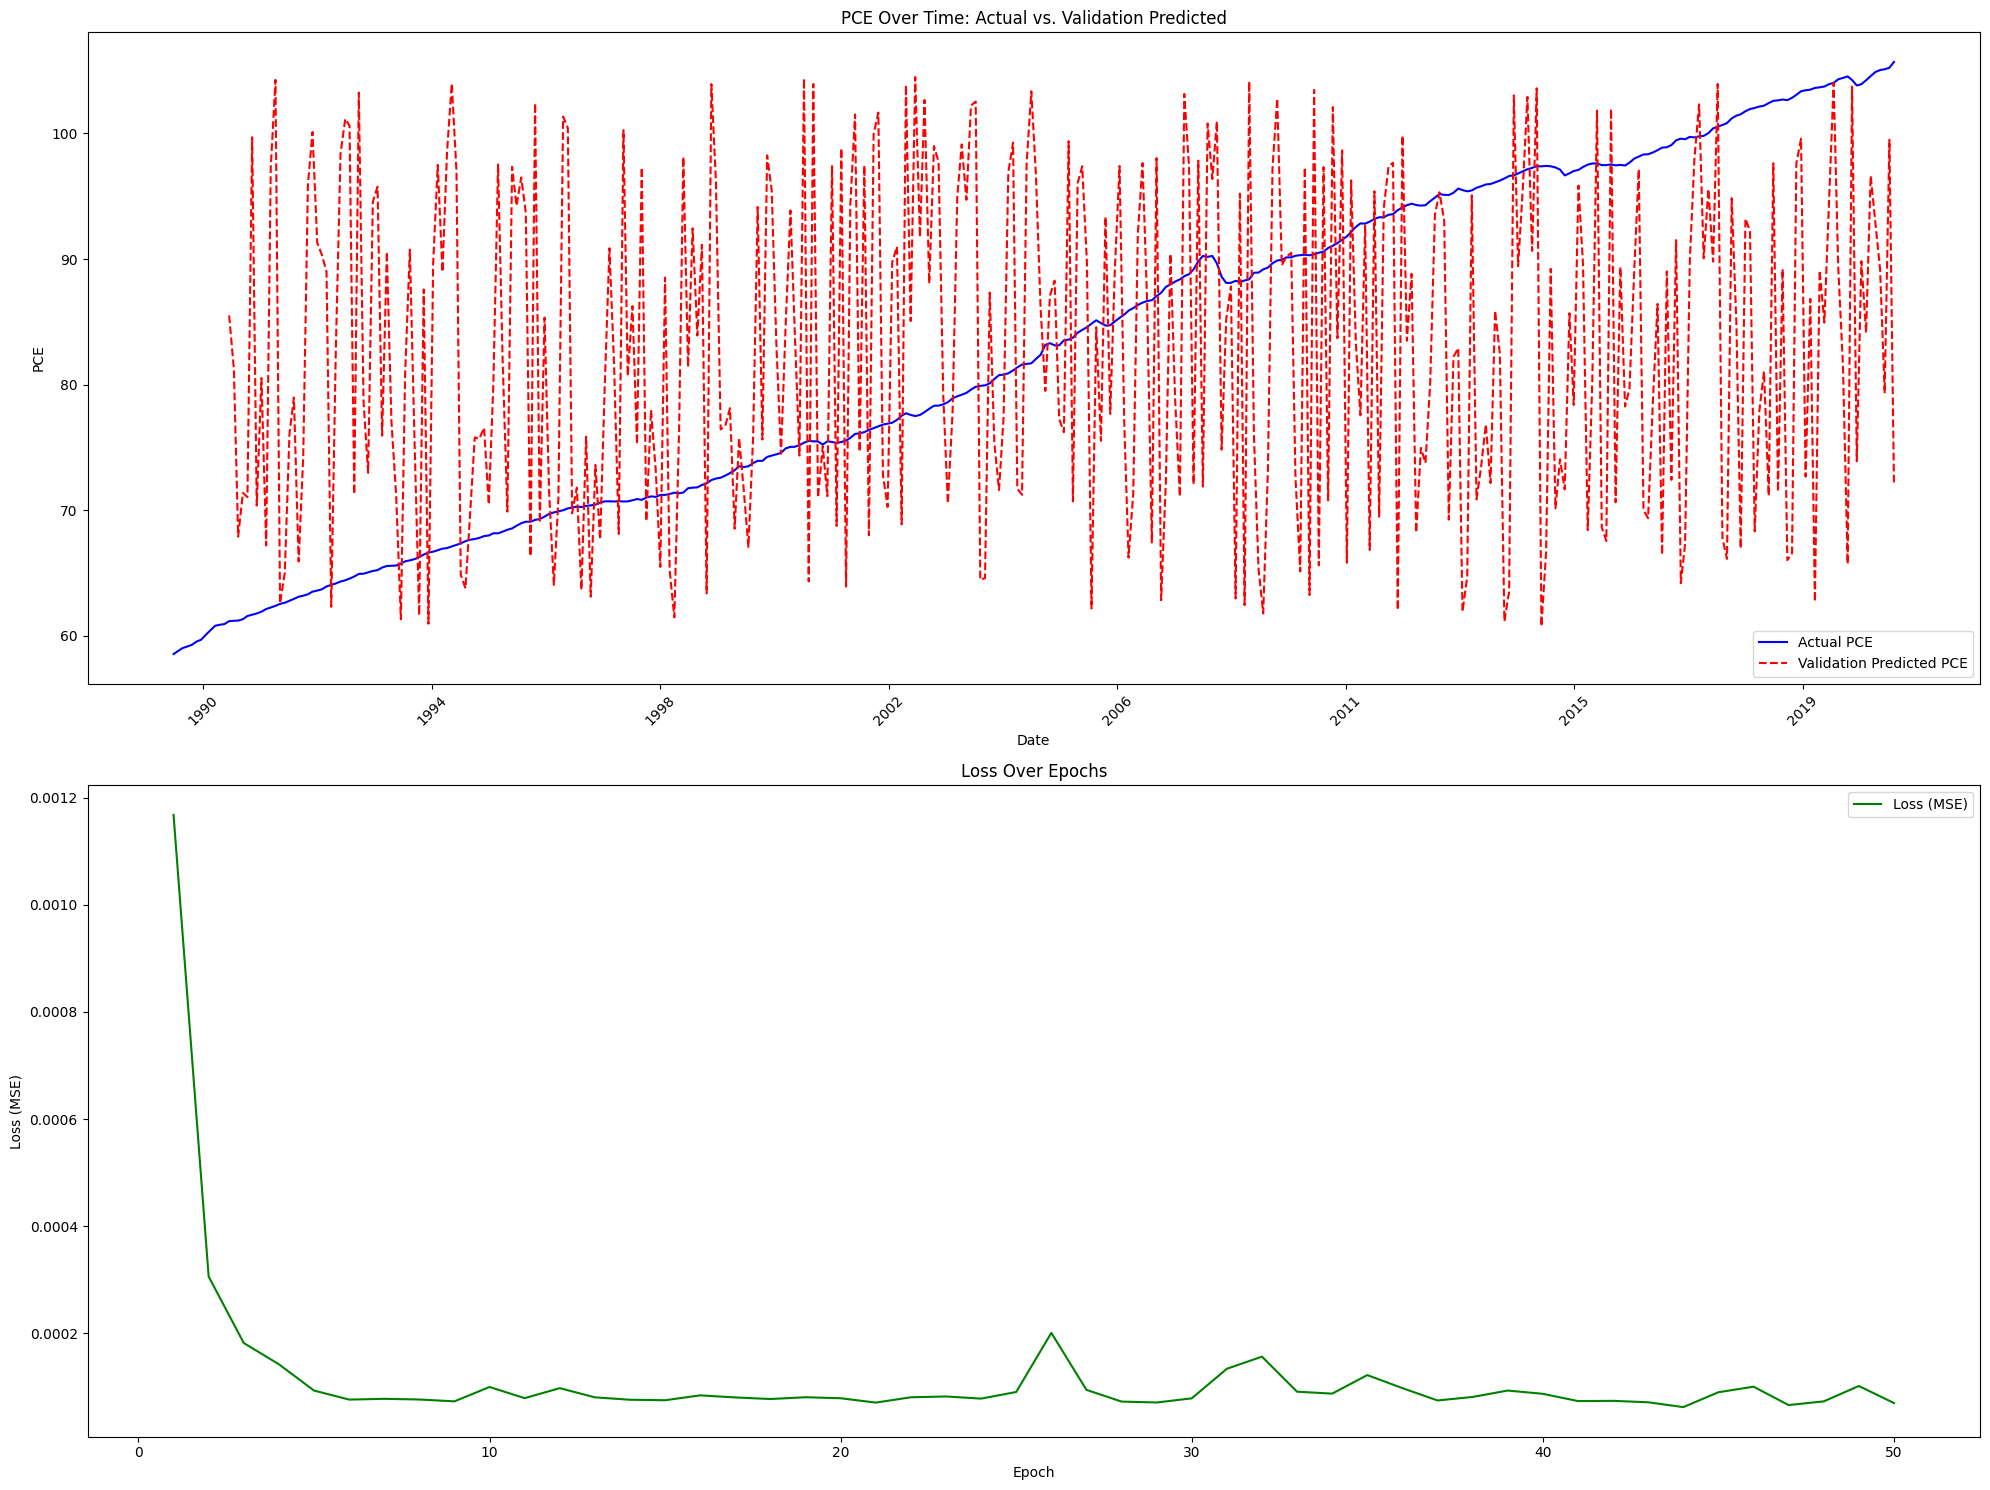

In [32]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 15))

# Plot actual and predicted PCE values on the first subplot
ax1.xaxis.set_major_locator(plt.MaxNLocator(10))
ax1.locator_params(axis='x', nbins=10)
ax1.plot(train_df.index, train_df['PCE'], label='Actual PCE', linestyle='-', color='blue')
ax1.plot(dates[:len(predictions_inv)], predictions_inv, label='Validation Predicted PCE', linestyle='--', color='red')
ax1.set_title("PCE Over Time: Actual vs. Validation Predicted")
ax1.set_xlabel("Date")
ax1.set_ylabel("PCE")
ax1.legend()
ax1.tick_params(axis='x', rotation=45)

# --- Plot 2: Loss over Epochs ---
ax2.plot(range(1, num_epochs+1), validation_losses, label='Loss (MSE)', color='green')
ax2.set_title("Loss Over Epochs")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss (MSE)")
ax2.legend()

plt.tight_layout()
plt.show()